In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split

from bikesharing.ml_logic.model import get_folds, train_test_indices
from bikesharing.interface.main import *
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

from bikesharing.params import *

In [23]:
X = pd.read_csv(f'{LOCAL_DATA_PATH}/processed/introduce_weekday_features.csv').drop(columns='Unnamed: 0')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   is_holiday            35040 non-null  int64  
 1   is_weekend            35040 non-null  int64  
 2   temperature_2m        35040 non-null  float64
 3   apparent_temperature  35040 non-null  float64
 4   windspeed_10m         35040 non-null  float64
 5   precipitation         35040 non-null  float64
 6   hour_sin              35040 non-null  float64
 7   hour_cos              35040 non-null  float64
 8   month_sin             35040 non-null  float64
 9   month_cos             35040 non-null  float64
 10  day_sin               35040 non-null  float64
 11  day_cos               35040 non-null  float64
 12  weekday_sin           35040 non-null  float64
 13  weekday_cos           35040 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 3.7 MB


In [24]:
y = pd.read_csv(f'{LOCAL_DATA_PATH}/processed/y_processed_from_2019_to_2022.csv')
y.head()

,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,Laim,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
districts = y.columns

In [26]:
data = pd.concat([X,y] , axis=1)
data.shape

(35064, 48)

In [27]:
fold_dfs = get_folds(data, fold_length=8760, fold_stride=8760)

In [30]:
models = []
district_score_means = []

for dist in districts:
    scores_list = []

    indices = [0, 1, 2, 3]
        
    for id in range(4):
        xgb_r = XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)

        test_df = fold_dfs[id]
        train_folds = [fold_dfs[i] for i in indices if i != id]
        
        train_df = pd.concat(train_folds, axis=0)
        X_test = test_df.drop(columns= districts)
        y_test = test_df[dist]
        X_train = train_df.drop(columns= districts)
        y_train = train_df[dist]
        
        xgb_r.fit(X_train, y_train)
        y_pred = [x if x >= 0 else 0 for x in xgb_r.predict(X_test)]
        #scores = r2_score(y_test , y_pred)
        scores = mean_squared_log_error(y_test, y_pred)
        scores_list.append(scores)
    
    print(f"{id} >>> scores={scores_list}")
            
    scores_array = np.array(scores)
    district_score_means.append(np.mean(scores_array.flatten()))

3 >>> scores=[0.4828069145064155, 0.49623883277616065, 0.4276029014112754, 0.37799198915415405]
3 >>> scores=[0.41514576129953396, 0.36663056180403125, 0.307830090265816, 0.31272913609623954]
3 >>> scores=[0.14971097601979913, 0.17356491882437428, 0.11760388501943315, 0.13135670063392468]
3 >>> scores=[0.2662699600234248, 0.2591665292099072, 0.2546026598707793, 0.25894967182748296]
3 >>> scores=[0.32530824794202184, 0.3081530126959346, 0.315310665594884, 0.3178869782369855]
3 >>> scores=[0.030726479853261508, 0.05945400166762352, 0.016656695093009415, 0.0183264453907179]
3 >>> scores=[0.21812550526935523, 0.213947968805961, 0.19164844464116776, 0.21040071151404852]
3 >>> scores=[0.09814210012910063, 0.10024017011592229, 0.08372214384902257, 0.08950005625834458]
3 >>> scores=[0.07955576720041305, 0.0818545228175184, 0.03544425949707937, 0.037303259993009985]
3 >>> scores=[0.29966663283094663, 0.2871459929208375, 0.28416693945037874, 0.29248034177402626]
3 >>> scores=[0.01006713471891758

In [36]:
pd.DataFrame({'mean score':district_score_means}, index=districts).sort_values(by='mean score', ascending=False)

,mean score
Altstadt-Lehel,0.377992
Schwabing-Freimann,0.376678
Milbertshofen-Am Hart,0.363782
Ludwigsvorstadt-Isarvorstadt,0.355871
Moosach,0.325163
Maxvorstadt,0.324982
Neuhausen-Nymphenburg,0.322129
Sendling,0.321754
Bogenhausen,0.317887
Au - Haidhausen,0.312729


In [37]:
xgb_r = XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)

test_df = fold_dfs[3]
train_folds = [fold_dfs[i] for i in indices if i != 3]
        
train_df = pd.concat(train_folds, axis=0)
X_test = test_df.drop(columns=districts)
y_test = test_df['Altstadt-Lehel']
X_train = train_df.drop(columns=districts)
y_train = train_df['Altstadt-Lehel']

xgb_r.fit(X_train, y_train)
y_pred = xgb_r.predict(X_test)

Text(0.5, 1.0, 'y_pred')

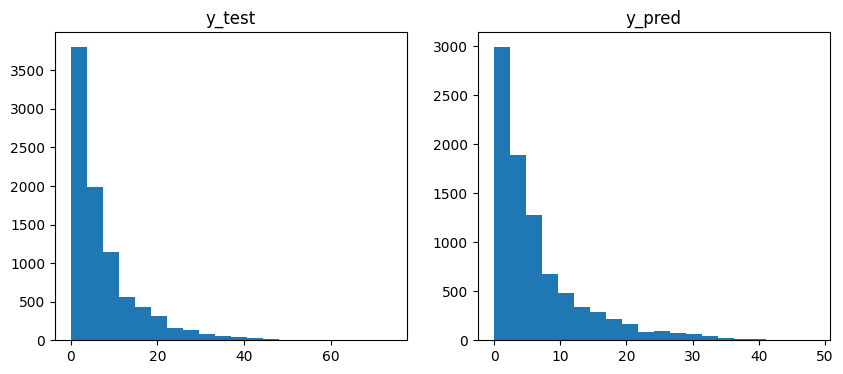

In [62]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(y_test, bins=20)
ax[0].set_title('y_test')
ax[1].hist(y_pred, bins=20)
ax[1].set_title('y_pred')

list

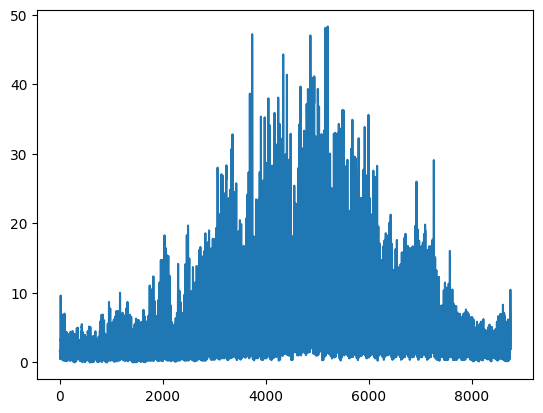

In [40]:
plt.plot(y_pred)

In [66]:
from sklearn.preprocessing import KBinsDiscretizer

est = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
y_test_bins = est.fit_transform(pd.DataFrame(y_test))
y_pred_bins = est.transform(pd.DataFrame(y_pred))

/home/sandra/.pyenv/versions/3.10.6/envs/bike_sharing_demand/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KBinsDiscretizer was fitted with feature names
  warnings.warn(


In [67]:
mean_squared_log_error(y_test_bins, y_pred_bins)

0.2158114378717189

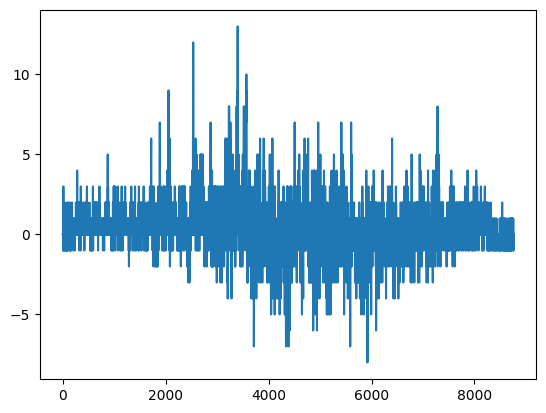

In [82]:
residuals = y_test_bins-y_pred_bins
plt.plot(residuals);

In [83]:
est.bin_edges_

array([array([ 0. ,  3.7,  7.4, 11.1, 14.8, 18.5, 22.2, 25.9, 29.6, 33.3, 37. ,
              40.7, 44.4, 48.1, 51.8, 55.5, 59.2, 62.9, 66.6, 70.3, 74. ])     ],
      dtype=object)

In [94]:
y.describe()

,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,Laim,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,...,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,6.599390,3.466205,0.279432,1.171515,2.344484,0.055698,0.583077,0.216148,0.110541,1.556411,...,1.982090,3.101044,1.547313,0.123403,0.606063,0.323266,0.323266,1.808122,1.808122,0.019336
std,8.541564,3.959244,0.711903,1.600599,3.001915,0.293199,1.068778,0.570971,0.392132,1.979982,...,2.438443,3.909491,2.101708,0.390364,1.268230,0.755566,0.755566,2.480779,2.480779,0.156875
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,9.000000,5.000000,0.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,2.000000,...,3.000000,4.000000,2.000000,0.000000,1.000000,0.000000,0.000000,3.000000,3.000000,0.000000
max,75.000000,35.000000,10.000000,14.000000,39.000000,7.000000,15.000000,8.000000,9.000000,24.000000,...,23.000000,37.000000,18.000000,6.000000,26.000000,12.000000,12.000000,24.000000,24.000000,6.000000


In [96]:
pd.DataFrame(y.describe().loc['max'], index=districts).sort_values(by='max', ascending=False)

,max
Milbertshofen-Am Hart,121.0
Maxvorstadt,92.0
Schwabing-Freimann,81.0
Altstadt-Lehel,75.0
Ludwigsvorstadt-Isarvorstadt,72.0
Neuhausen-Nymphenburg,64.0
Schwabing-West,55.0
Bogenhausen,39.0
Sendling,37.0
Au - Haidhausen,35.0


In [98]:
r2_score(y_test, y_pred)

0.6084474886740192

In [99]:
X.head()

,is_holiday,is_weekend,temperature_2m,apparent_temperature,windspeed_10m,precipitation,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos
0,1,0,0.355408,0.342007,0.227848,0.017391,0.629410,0.982963,0.75,0.933013,0.600779,0.989739,1.0,0.356896
1,1,0,0.357616,0.340149,0.245570,0.008696,0.750000,0.933013,0.75,0.933013,0.600779,0.989739,1.0,0.356896
2,1,0,0.359823,0.336431,0.303797,0.017391,0.853553,0.853553,0.75,0.933013,0.600779,0.989739,1.0,0.356896
3,1,0,0.359823,0.332714,0.341772,0.008696,0.933013,0.750000,0.75,0.933013,0.600779,0.989739,1.0,0.356896
4,1,0,0.359823,0.332714,0.356962,0.000000,0.982963,0.629410,0.75,0.933013,0.600779,0.989739,1.0,0.356896


In [112]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(y.T)

/home/sandra/.pyenv/versions/3.10.6/envs/bike_sharing_demand/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [113]:
pd.DataFrame({'labels':kmeans.labels_}, index=y.columns).sort_values(by='labels')

,labels
Untermenzing-Allach,0
Pasing,0
Pasing-Obermenzing,0
Ramersdorf-Perlach,0
Südgiesing,0
Lochhausen,0
Thalkirchen,0
Obersendling,0
Hasenbergl-Lerchenau Ost,0
Hadern,0
